# Influence metric computation
In this notebook, we carry out a t-test in order to assess the variation of the baby naming at the release of a movie.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats

## 1. Methodology

The computation is made as follows. First, we pick the 10 datapoints (10 years) before the movie release and we compute the difference between adjacent values to get the variation . It is done as follows :

`difference = datapoints[:-1] - datapoints[1:]`

Then we do the same for the 5 datapoints after the movie release. Finally a t-test is carried out between the two difference arrays.
We keep the p-value which will tell us if the variation at the movie release is significant or not and the t-statistic which will indicate if the variation is positive or negative. We decided to chose a signifiance level of 0.1

We first carry the computation on a single movie and a single name to be able to plot the data with regression lines to validate the methodology visually.

The regression is then carried out for each of the character name in the name_by_movie_ordered_df dataframe by adding a column for the t-statistic value and the p-value.

## 2. Import processed data

We need three dataframes present in the preprocessed folder.
1. `movie_df` : to have the release date
2. `name_by_movie_ordered_df` : to have the character name and their corresponding movies. The p-value and t-statistic will be added there.
3. `baby_name_df` : to have the data on the baby name

In [2]:
folder_processed_data_path = './data/processed_data/'

# import movie_df to get the release date
movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_df.csv'))
movie_df.set_index(['wiki_ID'], inplace=True)

# import name_by_movie_ordered_df to get the character name and their corresponding movies. 
name_by_movie_ordered_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_df.csv'))

baby_name_df = pd.read_csv(os.path.join(folder_processed_data_path, 'baby_name_df.csv'))

print("movie_df :")
display(movie_df.head())
print("name_by_movie_ordered_df :")
display(name_by_movie_ordered_df.head())
print("baby_name_df :")
display(baby_name_df.head())

movie_df :


,mov_name,year,month,revenue,numVotes,averageRating
wiki_ID,,,,,,
975900,Ghosts of Mars,2001,8.0,14010832.0,56880,4.9
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,2.0,NaN,69,6.0
28463795,Brun bitter,1988,NaN,NaN,40,5.6
9363483,White Of The Eye,1987,NaN,NaN,2891,6.1
261236,A Woman in Flames,1983,NaN,NaN,623,5.9


name_by_movie_ordered_df :


,wiki_ID,char_words,order,gender
0,3217,Gold,6.0,NaN
1,3217,Linda,7.0,F
2,3217,Henry,4.0,M
3,3217,Duke,4.0,M
4,3217,Warrior,9.0,M


baby_name_df :


,name,year,number,percentage
0,Aaban,2007,5,0.000125
1,Aadam,2007,8,0.000200
2,Aadan,2007,8,0.000200
3,Aadarsh,2007,13,0.000325
4,Aaden,2007,157,0.003928


## 3. Testing computation on a single movie, one character name
### 3.1 Data setup
Let's choose the famous movie "Pulp Fiction" and the character `Mia`

In [3]:
nb_year_after = 5
nb_year_before = 10

In [4]:
# search the movie ID
chosen_movie_name = "Pulp Fiction"
movie_df.query("mov_name == @chosen_movie_name")

,mov_name,year,month,revenue,numVotes,averageRating
wiki_ID,,,,,,
54173,Pulp Fiction,1994,5.0,213928762.0,2158972,8.9


In [5]:
chosen_name = 'Mia'
chosen_movie_ID = 54173

print(f"The chosen character is {chosen_name} in the movie \"{movie_df.loc[chosen_movie_ID]['mov_name']}\" released in {movie_df.loc[chosen_movie_ID]['year']}")

The chosen character is Mia in the movie "Pulp Fiction" released in 1994


In [6]:
# filter the baby name dataframe to get only the data of "Mia" baby name
chosen_baby_name_df = baby_name_df.query("name == @chosen_name").sort_values(by=['year'])

In [7]:
# get the release date
release_year = movie_df.loc[chosen_movie_ID]['year']
print(f"release year = {release_year}")

release year = 1994


We select the range of years before and after the movie release coresponding to the baby name data, with the corresponding percentage of babies with this name:

In [8]:
before_df = chosen_baby_name_df[(chosen_baby_name_df.year >= release_year-nb_year_before) & (chosen_baby_name_df.year <= release_year-1)].reset_index()
after_df = chosen_baby_name_df[(chosen_baby_name_df.year >= release_year) & (chosen_baby_name_df.year <= release_year+nb_year_after-1)].reset_index()
display(before_df)
display(after_df)

,index,name,year,number,percentage
0,1063571,Mia,1984,452,0.012956
1,919241,Mia,1985,500,0.014009
2,987399,Mia,1986,491,0.013804
3,532222,Mia,1987,549,0.015227
4,552385,Mia,1988,620,0.016781
5,1084086,Mia,1989,676,0.017584
6,1106338,Mia,1990,783,0.019812
7,1009048,Mia,1991,779,0.020000
8,940991,Mia,1992,822,0.021401
9,575113,Mia,1993,800,0.021220


,index,name,year,number,percentage
0,598990,Mia,1994,861,0.023162
1,622966,Mia,1995,1102,0.030094
2,647140,Mia,1996,1690,0.046340
3,671982,Mia,1997,2495,0.068818
4,697404,Mia,1998,2566,0.069767


Let's plot the curve and highlight the release date.

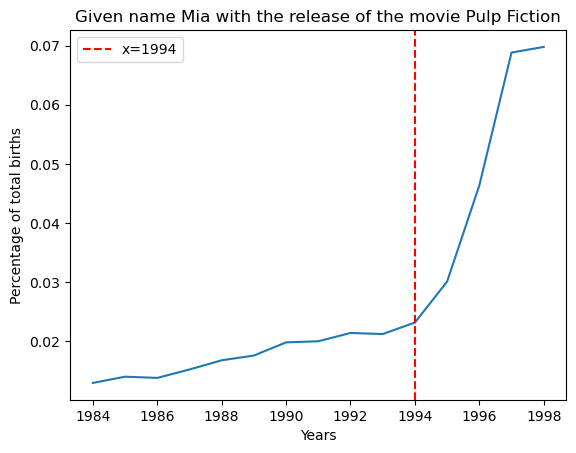

In [9]:
union_before_after_df = pd.concat([before_df, after_df], ignore_index=True)

x_values = union_before_after_df['year'].values
y_values = union_before_after_df['percentage'].values

# Create a scatter plot
plt.plot(x_values, y_values)
plt.xlabel('Years')
plt.ylabel('Percentage of total births')
plt.title(f'Given name {chosen_name} with the release of the movie {movie_df.loc[chosen_movie_ID].mov_name}')

# Draw vertical lines for each movie release
plt.axvline(x=release_year, color='r', linestyle='--', label=f'x={release_year}')
plt.legend()

plt.show()

### 3.2 Compute regression
Lets now carry out a linear regression on both side of the release date.

In [10]:
# model before release
mod_before = smf.ols(formula = 'percentage ~ year' , data = before_df)
np.random.seed(2)
res_before = mod_before.fit()

coefficients_before = res_before.params.values
beta_before = coefficients_before[1]
intercept_before = coefficients_before[0]

# model after release
mod_after = smf.ols(formula = 'percentage ~ year' , data = after_df)
res_after = mod_after.fit()

coefficients_after = res_after.params.values
beta_after = coefficients_after[1]
intercept_after = coefficients_after[0]

print("Before release : ")
print(f"   beta = {beta_before:.4f}, intercept = {intercept_before:.2f} \n")

print("After release : ")
print(f"   beta = {beta_after:.4f}, intercept = {intercept_after:.2f}")

Before release : 
   beta = 0.0010, intercept = -2.05 

After release : 
   beta = 0.0132, intercept = -26.29


And plot the regression lines.

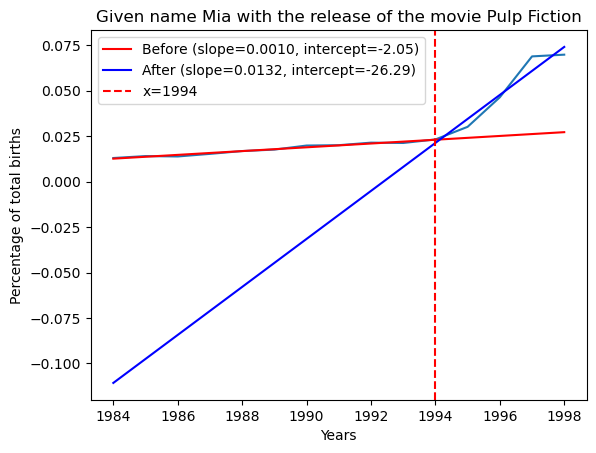

In [11]:
union_before_after_df = pd.concat([before_df, after_df], ignore_index=True)

x_values = union_before_after_df['year'].values
y_values = union_before_after_df['percentage'].values

# Create a scatter plot
plt.plot(x_values, y_values)
plt.xlabel('Years')
plt.ylabel('Percentage of total births')
plt.title(f'Given name {chosen_name} with the release of the movie {movie_df.loc[chosen_movie_ID].mov_name}')

# Calculate y values for the regression lines
reg_before = beta_before * x_values + intercept_before
reg_after = beta_after * x_values + intercept_after
# Plot the regression lines
plt.plot(x_values, reg_before, label=f'Before (slope={beta_before:.4f}, intercept={intercept_before:.2f})', color='red')
plt.plot(x_values, reg_after, label=f'After (slope={beta_after:.4f}, intercept={intercept_after:.2f})', color='blue')

# Draw vertical lines for each movie release
plt.axvline(x=release_year, color='r', linestyle='--', label=f'x={release_year}')
plt.legend()

plt.show()

### 3.3 T-test
Now we carry out a t-test on the two regression lines.

In [12]:
before_diffs = before_df['percentage'][:-1] - before_df['percentage'][1:].values
after_diffs = after_df['percentage'][:-1] - after_df['percentage'][1:].values

# Assuming you're comparing the slopes of the two regression models
t_stat, p_value = stats.ttest_ind(before_diffs, after_diffs)

print("T-statistic:", t_stat)
print("P-value:",p_value)

T-statistic: 3.5352767451178595
P-value: 0.004671320071359155


We have a p-value lower than 0.1, therefore the variation is signification with our significance level. The t-statistic shows that it is an increase.

## 4. Computation for all movie and character
Here the same computation is done for all characters of all movie using the apply method on the dataframe name_by_movie.

The computation is time-consuming (25min). Therefore the output is not there.

In [13]:
iter = 0

nb_yr_before = 10
nb_yr_after = 5

# Function to calculate total income (salary + bonus)
def apply_regression(row):
    global iter

    chosen_movie_ID = row['wiki_ID']
    chosen_name = row['char_words']
    
    chosen_baby_name_df = baby_name_df.query("name == @chosen_name").sort_values(by=['year'])

    release_year = movie_df.loc[chosen_movie_ID]['year']
    
    before_df = chosen_baby_name_df[(chosen_baby_name_df.year >= release_year-nb_year_before) & (chosen_baby_name_df.year <= release_year-1)].reset_index()
    after_df = chosen_baby_name_df[(chosen_baby_name_df.year >= release_year) & (chosen_baby_name_df.year <= release_year+nb_year_after-1)].reset_index()
    
    if (len(before_df) != nb_yr_before) or (len(after_df) != nb_yr_after):
        # print("not enough datapoints : return NaN")
        row['t_stat'] = np.NaN
        row['p_value'] = np.NaN
    else:
        before_diffs = before_df['percentage'][:-1] - before_df['percentage'][1:].values
        after_diffs = after_df['percentage'][:-1] - after_df['percentage'][1:].values

        # Assuming you're comparing the slopes of the two regression models
        t_stat, p_value = stats.ttest_ind(before_diffs, after_diffs)

        row['t_stat'] = t_stat
        row['p_value'] = p_value
        row['slope_change'] = after_diffs.mean()-before_diffs.mean()

    iter += 1
    print("Batch {} of {}".format(iter, len(name_by_movie_ordered_df)), end="\r")
    
    # print(f"Movie ID : {chosen_movie_ID}, Name : {chosen_name}, P-VALUE = {p_value}")
    return row

# Apply the function to create a new 'TotalIncome' column
name_by_movie_ordered_pvalue_df = name_by_movie_ordered_df.copy(deep=True)
name_by_movie_ordered_pvalue_df = name_by_movie_ordered_pvalue_df.apply(apply_regression, axis=1)

display(name_by_movie_ordered_pvalue_df.head())

,char_words,gender,order,p_value,slope_change,t_stat,wiki_ID
0,Gold,NaN,6.0,NaN,NaN,NaN,3217
1,Linda,F,7.0,0.676072,-0.000675,0.429187,3217
2,Henry,M,4.0,0.068422,-0.002435,2.019954,3217
3,Duke,M,4.0,0.582585,0.000108,-0.566260,3217
4,Warrior,M,9.0,NaN,NaN,NaN,3217


Export the new name_by_movie dataframe with the result of the t-test.

In [14]:
processed_folder = './data/processed_data/'
name_by_movie_ordered_pvalue_df.to_csv(os.path.join(processed_folder, 'name_by_movie_ordered_pvalue_10_5_df.csv'), index=False)

## 5. Results

In [15]:
name_by_movie = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_pvalue_10_5_df.csv'))

Now lets see how many of the movie character have a significant impact.

In [16]:
significant_names = len(name_by_movie[name_by_movie['p_value'] <= 0.1])/len(name_by_movie)
print(f"Proportion of significant character name : {significant_names*100:.2f}%")

Proportion of significant character name : 13.71%


From our analysis, we get that 13.71% of the names have a significant variation after the movie release.

In [17]:
not_significant_names = len(name_by_movie[name_by_movie['p_value'] >= 0.1])/len(name_by_movie)
print(f"Proportion of non significant character name : {not_significant_names*100:.2f}%")

Proportion of non significant character name : 55.08%


In [18]:
nan_p_values = len(name_by_movie[name_by_movie['p_value'].isna()])/len(name_by_movie)
print(f"Proportion of non calculated character name : {nan_p_values*100:.2f}%")

Proportion of non calculated character name : 31.21%


The last proportion concerns the case where there were missing baby name data in the area of the movie release to carry out the t-test.

In [19]:
nb_movie_significant = len(name_by_movie[name_by_movie['p_value'] <= 0.1]['wiki_ID'].unique())
print(f"The number of movie that have a significiant variation in one of its character name given to baby is : {nb_movie_significant}")

The number of movie that have a significiant variation in one of its character name given to baby is : 12264


In [20]:
percent_movie_significant = (nb_movie_significant / len(movie_df))*100
print(f"Therefore, {percent_movie_significant:.2f}% of the movies have one of its characters that shows to have caused a variation on baby naming at the movie release.")

Therefore, 18.72% of the movies have one of its characters that shows to have caused a variation on baby naming at the movie release.
